# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers, Sequential
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Dense
from keras.layers import LSTM,Input
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [2]:
# Read the data
data=pd.read_csv("generated_data.csv")

In [3]:
data

,timestamp,temperature,pressure,humidity,temperature_status,pressure_status,humidity_status
0,2023-01-01 00:00:00,28.10,105.27,32.26,normal,normal,anomalous
1,2023-01-01 00:05:00,22.53,102.69,71.83,anomalous,normal,anomalous
2,2023-01-01 00:10:00,34.63,100.23,65.88,normal,normal,normal
3,2023-01-01 00:15:00,25.32,81.32,74.68,normal,anomalous,anomalous
4,2023-01-01 00:20:00,28.75,97.69,42.93,normal,normal,normal
...,...,...,...,...,...,...,...
995,2023-01-04 10:55:00,39.72,109.03,57.36,anomalous,normal,normal
996,2023-01-04 11:00:00,38.78,103.67,77.07,anomalous,normal,anomalous
997,2023-01-04 11:05:00,35.97,111.50,72.28,anomalous,anomalous,anomalous
998,2023-01-04 11:10:00,24.67,95.94,68.69,anomalous,normal,normal


# Humidity sensor

#### Convert the humidity status from catorigical to numerical

In [4]:
# Select the timestamp,humidity column and the humidity_status column from the data
data_humidity = data.loc[:, ['timestamp', 'humidity',"humidity_status"]]
data_humidity

,timestamp,humidity,humidity_status
0,2023-01-01 00:00:00,32.26,anomalous
1,2023-01-01 00:05:00,71.83,anomalous
2,2023-01-01 00:10:00,65.88,normal
3,2023-01-01 00:15:00,74.68,anomalous
4,2023-01-01 00:20:00,42.93,normal
...,...,...,...
995,2023-01-04 10:55:00,57.36,normal
996,2023-01-04 11:00:00,77.07,anomalous
997,2023-01-04 11:05:00,72.28,anomalous
998,2023-01-04 11:10:00,68.69,normal


In [5]:
# Convert the humidity_status column to binary values
data_humidity.loc[data_humidity["humidity_status"]=="normal","humidity_status"]=0
data_humidity.loc[data_humidity["humidity_status"]=="anomalous","humidity_status"]=1
data_humidity

,timestamp,humidity,humidity_status
0,2023-01-01 00:00:00,32.26,1
1,2023-01-01 00:05:00,71.83,1
2,2023-01-01 00:10:00,65.88,0
3,2023-01-01 00:15:00,74.68,1
4,2023-01-01 00:20:00,42.93,0
...,...,...,...
995,2023-01-04 10:55:00,57.36,0
996,2023-01-04 11:00:00,77.07,1
997,2023-01-04 11:05:00,72.28,1
998,2023-01-04 11:10:00,68.69,0


In [6]:
def standraization(df, column_name):
    # Calculate Z-scores
    z_scores = np.abs((df[column_name] - df[column_name].mean()) / df[column_name].std())
    df["humidity_standar"]=z_scores
    return df

In [7]:
data_humidity["humidity"].min(), data_humidity["humidity"].max()

(30.09, 79.91)

##### Analysing the data readout and plot a sample

In [8]:
# The number of normal and anomalous humidity values
data_humidity.loc[data_humidity["humidity_status"]==0]["timestamp"].count(), data_humidity.loc[data_humidity["humidity_status"]==1]["timestamp"].count()

(601, 399)

In [9]:
# The range of timestamps
data_humidity["timestamp"].min(), data_humidity["timestamp"].max()

('2023-01-01 00:00:00', '2023-01-04 11:15:00')

In [10]:
# The number of humidity values recorded on the first two days
first_2days= data_humidity.loc[data_humidity["timestamp"]<'2023-01-03']
first_2days

,timestamp,humidity,humidity_status
0,2023-01-01 00:00:00,32.26,1
1,2023-01-01 00:05:00,71.83,1
2,2023-01-01 00:10:00,65.88,0
3,2023-01-01 00:15:00,74.68,1
4,2023-01-01 00:20:00,42.93,0
...,...,...,...
571,2023-01-02 23:35:00,75.94,1
572,2023-01-02 23:40:00,64.31,0
573,2023-01-02 23:45:00,53.92,0
574,2023-01-02 23:50:00,64.05,0


In [11]:
# The number of normal and anomalous humidity values recorded on the first two days
first_2days.loc[first_2days["humidity_status"]==0]["timestamp"].count(), first_2days.loc[first_2days["humidity_status"]==1]["timestamp"].count()

(341, 235)

In [12]:
therd_day= data_humidity.loc[(data_humidity["timestamp"]>'2023-01-03') & (data_humidity["timestamp"]<'2023-01-04')]

In [13]:
therd_day

,timestamp,humidity,humidity_status
576,2023-01-03 00:00:00,65.99,0
577,2023-01-03 00:05:00,44.20,0
578,2023-01-03 00:10:00,31.09,1
579,2023-01-03 00:15:00,52.76,0
580,2023-01-03 00:20:00,56.83,0
...,...,...,...
859,2023-01-03 23:35:00,56.31,0
860,2023-01-03 23:40:00,63.42,0
861,2023-01-03 23:45:00,72.43,1
862,2023-01-03 23:50:00,57.99,0


In [14]:
# The number of normal and anomalous humidity values recorded on the therd day
therd_day.loc[therd_day["humidity_status"]==0]["timestamp"].count(), therd_day.loc[therd_day["humidity_status"]==1]["timestamp"].count()

(183, 105)

In [15]:
# The number of temperature values recorded on the last day
last_day= data_humidity.loc[data_humidity["timestamp"]>='2023-01-04']
last_day

,timestamp,humidity,humidity_status
864,2023-01-04 00:00:00,67.93,0
865,2023-01-04 00:05:00,47.10,0
866,2023-01-04 00:10:00,79.69,1
867,2023-01-04 00:15:00,65.35,0
868,2023-01-04 00:20:00,43.16,0
...,...,...,...
995,2023-01-04 10:55:00,57.36,0
996,2023-01-04 11:00:00,77.07,1
997,2023-01-04 11:05:00,72.28,1
998,2023-01-04 11:10:00,68.69,0


In [16]:
# The number of normal and anomalous humidity values recorded on the last two days
last_day.loc[last_day["humidity_status"]==0]["timestamp"].count(), last_day.loc[last_day["humidity_status"]==1]["timestamp"].count()

(77, 59)

In [17]:
# Standarize the humidity values
first_2days=standraization(first_2days, "humidity")
therd_day=standraization(therd_day, "humidity")
last_day=standraization(last_day, "humidity")

C:\Users\adnan\AppData\Local\Temp\ipykernel_8816\2015214743.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["humidity_standar"]=z_scores
C:\Users\adnan\AppData\Local\Temp\ipykernel_8816\2015214743.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["humidity_standar"]=z_scores
C:\Users\adnan\AppData\Local\Temp\ipykernel_8816\2015214743.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [18]:
# first 7 rows
data_humidity.head(7)

,timestamp,humidity,humidity_status
0,2023-01-01 00:00:00,32.26,1
1,2023-01-01 00:05:00,71.83,1
2,2023-01-01 00:10:00,65.88,0
3,2023-01-01 00:15:00,74.68,1
4,2023-01-01 00:20:00,42.93,0
5,2023-01-01 00:25:00,71.43,1
6,2023-01-01 00:30:00,72.46,1


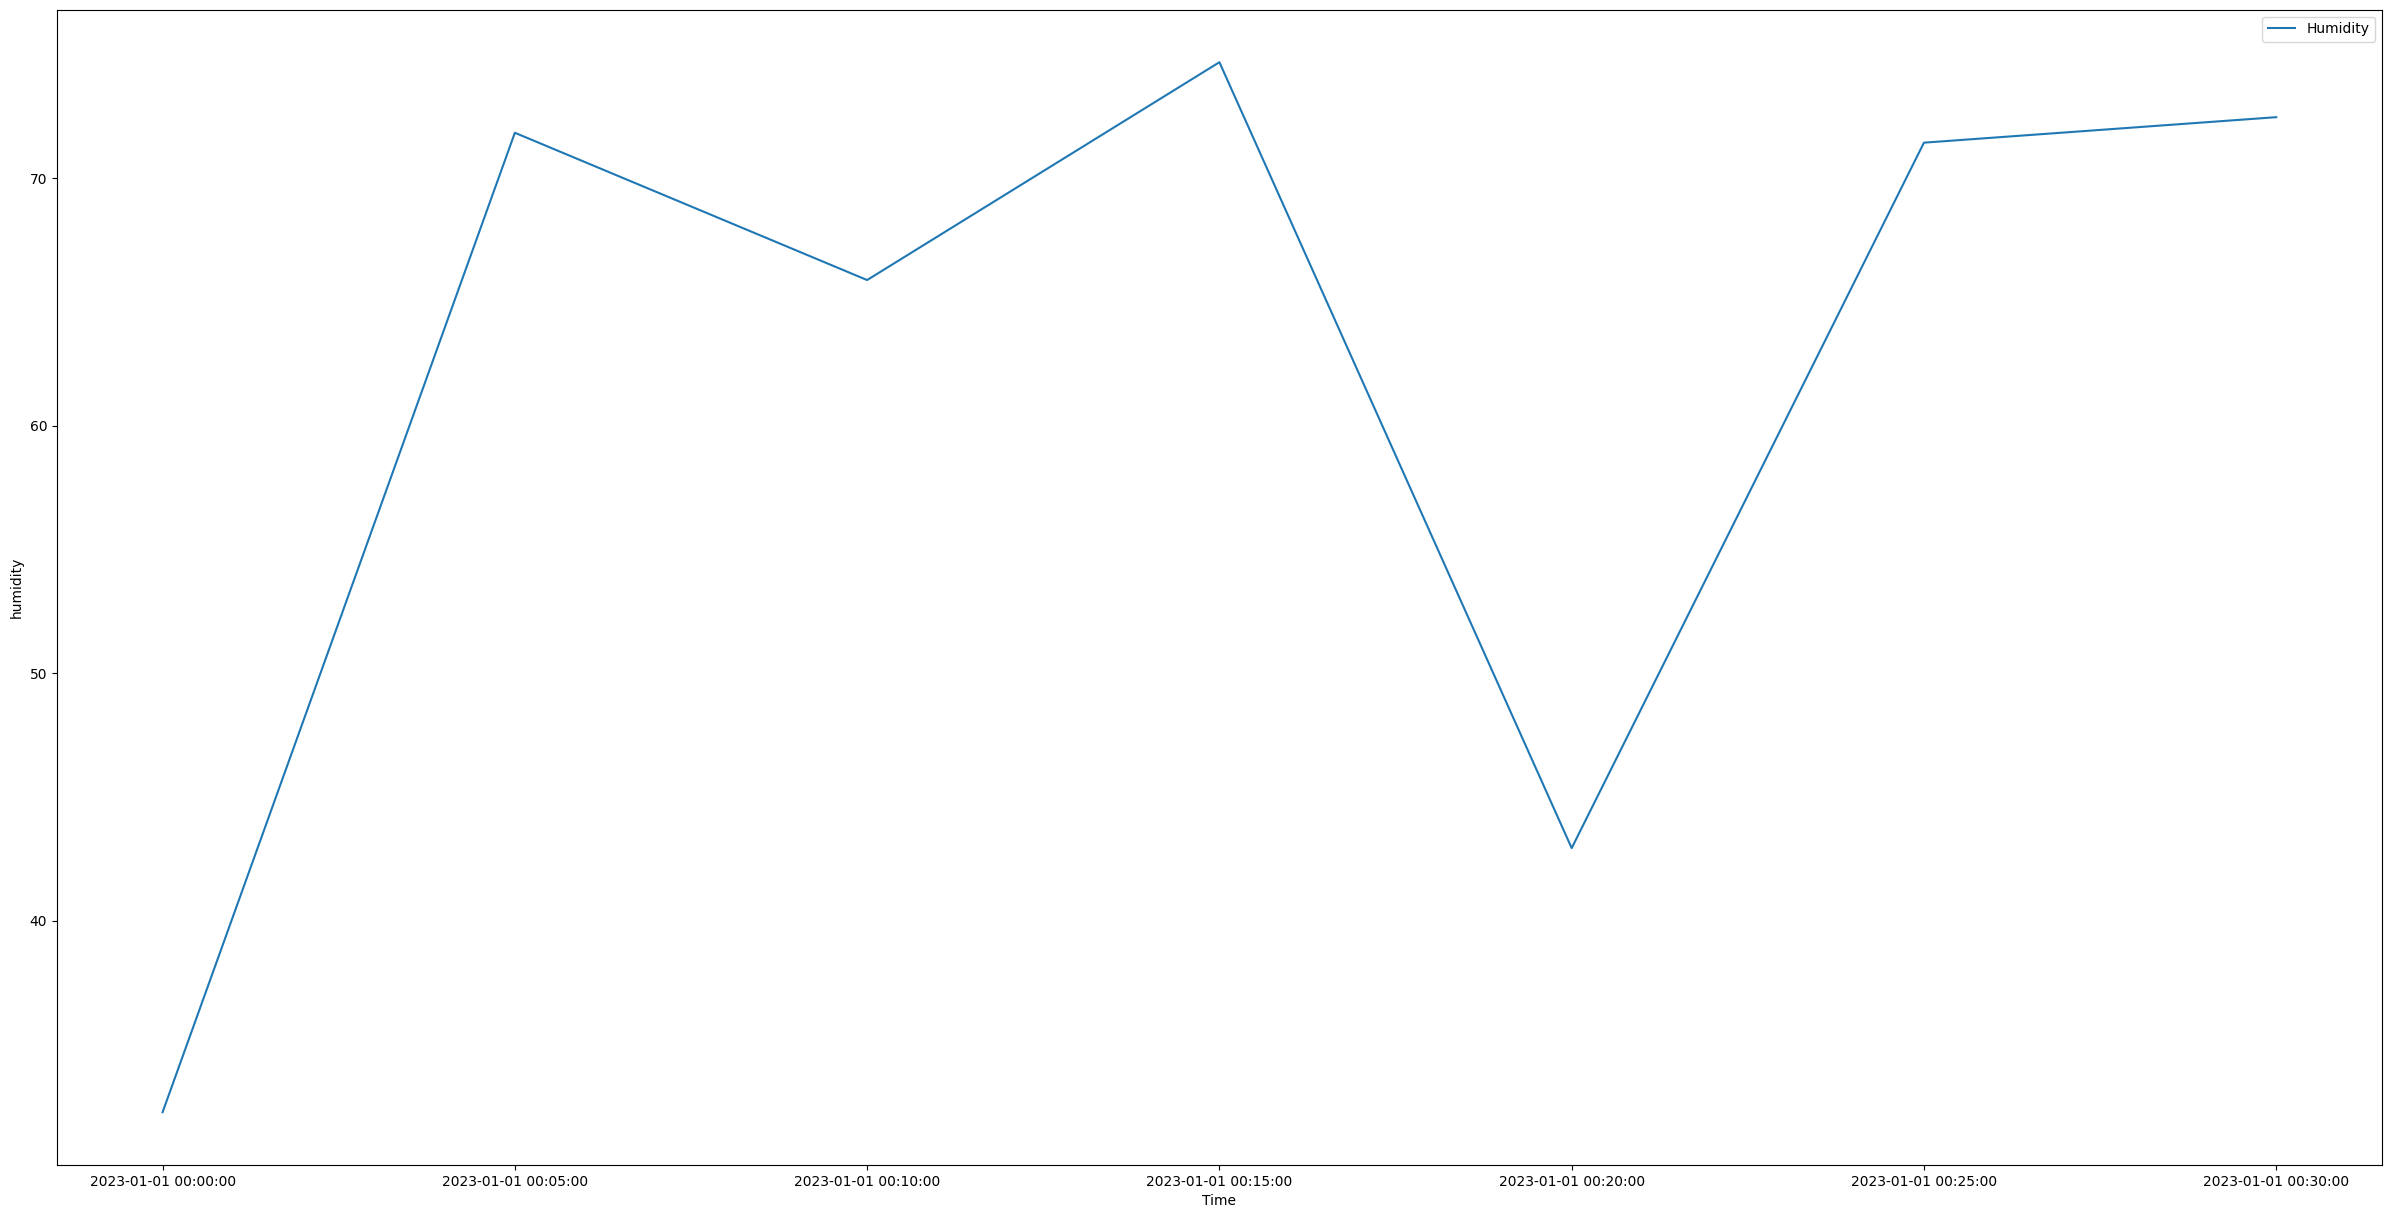

In [19]:
# Plot the first 7 temperature values
plt.figure(figsize=(30,15))
plt.plot(data_humidity["timestamp"].head(7), data_humidity["humidity"].head(7), label="Humidity")
plt.xlabel("Time")
plt.ylabel("humidity")
plt.legend()
plt.show()

- The data is balanced there are almost same number of reads out for each class.
- We can see the stand temperature can indicate a strong variasion between the previos temperatuer and the current one whcih help the model to idenife if there are some anomalous values.
- Window size of 1 readout which indicate a 5 minute.
- Split the data into test and train, the data are collected in 4 days, so train 2 days,valdation 1 day and test 1 day.

##### Spliting the data

In [20]:
train = first_2days
valdation= therd_day
test = last_day

In [21]:
train

,timestamp,humidity,humidity_status,humidity_standar
0,2023-01-01 00:00:00,32.26,1,1.540756
1,2023-01-01 00:05:00,71.83,1,1.186153
2,2023-01-01 00:10:00,65.88,0,0.776117
3,2023-01-01 00:15:00,74.68,1,1.382556
4,2023-01-01 00:20:00,42.93,0,0.805449
...,...,...,...,...
571,2023-01-02 23:35:00,75.94,1,1.469387
572,2023-01-02 23:40:00,64.31,0,0.667923
573,2023-01-02 23:45:00,53.92,0,0.048089
574,2023-01-02 23:50:00,64.05,0,0.650005


##### Preparing the data in sequences (number of samples, window size, number of features)

In [22]:
def sequence(data, timesteps, num_features):
    num_samples = len(data) - timesteps + 1  
    df = np.zeros((num_samples, timesteps, num_features))
    for i in range(num_samples):
        df[i] = data[i:i+timesteps, :] 

    return df

In [23]:
def prepare_y(train, timesteps):
    num_samples = len(train) - timesteps + 1
    y_train = np.zeros((num_samples, 1))
    for i in range(num_samples):
        y_train[i] = train["humidity_status"].values[i + timesteps - 1]

    return y_train

In [24]:
data_n= train.loc[train["humidity_status"]==0]
data_d = data_n.drop(['humidity',"humidity_status","timestamp"], axis=1).values
x_train = sequence(data_d, 1, 1)
x_train.shape

(341, 1, 1)

In [25]:
data_n= valdation.loc[valdation["humidity_status"]==0]
data_d = data_n.drop(['humidity',"humidity_status","timestamp"], axis=1).values
x_valdation = sequence(data_d, 1, 1)
x_valdation.shape

(183, 1, 1)

In [26]:
data_t = test.drop(['humidity',"humidity_status","timestamp"], axis=1).values
x_test = sequence(data_t, 1, 1)
x_test.shape

(136, 1, 1)

#### Autoencoder LSTM model

In [27]:

timesteps = x_train.shape[1]
n_features = x_train.shape[2]

lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(Input(shape=(timesteps, n_features)))
lstm_autoencoder.add(LSTM(16, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(64, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(128, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(256, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(512, activation="relu", return_sequences=False))

# Adding RepeatVector to match the input sequence length for decoding
lstm_autoencoder.add(RepeatVector(timesteps))

# Decoder
lstm_autoencoder.add(LSTM(512, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(256, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(128, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(64, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation="relu", return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 16)          │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 32)          │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1, 256)         │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 512)            │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 1, 512)         │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 1, 256)         │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 1, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 1, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 1, 16)          │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1, 1)           │            17 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,248,977 (20.02 MB)

 Trainable params: 5,248,977 (20.02 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Define the Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2,mode="min", verbose=1, restore_best_weights=True)

In [29]:
epochs = 400
batch = 32
lr = 0.0001
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.keras",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(x_train,x_train, 
                                                epochs=epochs, 
                                                batch_size=batch,
                                                validation_data=(x_valdation, x_valdation),
                                                callbacks=early_stopping,
                                                verbose=2).history


Epoch 1/400


11/11 - 7s - 655ms/step - loss: 0.3357 - val_loss: 0.3384
Epoch 2/400
11/11 - 0s - 16ms/step - loss: 0.3340 - val_loss: 0.3367
Epoch 3/400
11/11 - 0s - 16ms/step - loss: 0.3322 - val_loss: 0.3350
Epoch 4/400
11/11 - 0s - 16ms/step - loss: 0.3304 - val_loss: 0.3332
Epoch 5/400
11/11 - 0s - 19ms/step - loss: 0.3286 - val_loss: 0.3315
Epoch 6/400
11/11 - 0s - 17ms/step - loss: 0.3268 - val_loss: 0.3297
Epoch 7/400
11/11 - 0s - 17ms/step - loss: 0.3250 - val_loss: 0.3279
Epoch 8/400
11/11 - 0s - 16ms/step - loss: 0.3232 - val_loss: 0.3261
Epoch 9/400
11/11 - 0s - 17ms/step - loss: 0.3213 - val_loss: 0.3243
Epoch 10/400
11/11 - 0s - 16ms/step - loss: 0.3194 - val_loss: 0.3225
Epoch 11/400
11/11 - 0s - 17ms/step - loss: 0.3175 - val_loss: 0.3206
Epoch 12/400
11/11 - 0s - 16ms/step - loss: 0.3156 - val_loss: 0.3187
Epoch 13/400
11/11 - 0s - 16ms/step - loss: 0.3136 - val_loss: 0.3167
Epoch 14/400
11/11 - 0s - 17ms/step - loss: 0.3116 - val_loss: 0.3148
Epoch 15/400
11/11 - 0s - 19ms/step - lo

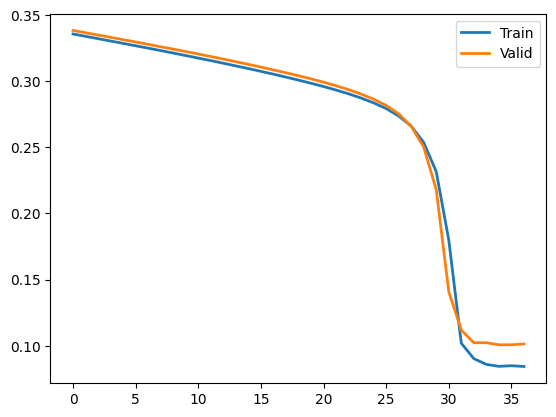

In [30]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Reconstruction error threshold: 0.5651580729688603


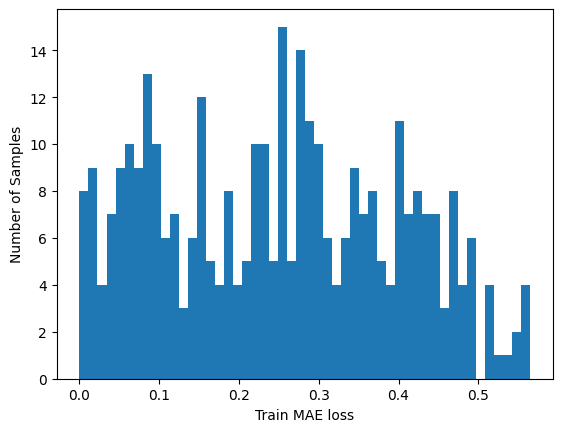

In [31]:
# Mean Absolute Error loss
x_train_pred = lstm_autoencoder.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Text(0, 0.5, 'Number of samples')

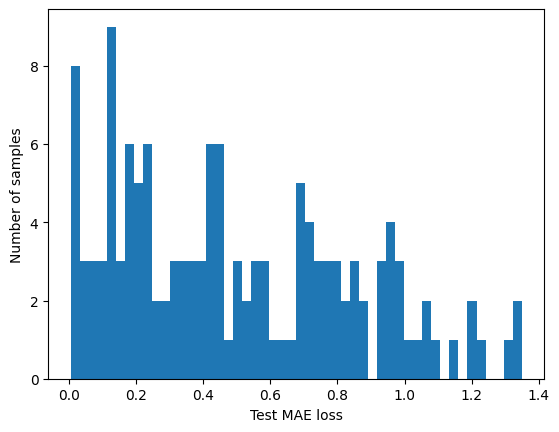

In [32]:
X_test_pred = lstm_autoencoder.predict(x_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-x_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [33]:
anomaly_df = test.copy()
anomaly_df.loc[:, 'loss'] = test_mae_loss
anomaly_df.loc[:, 'threshold'] = threshold
anomaly_df.loc[:, 'anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']
anomaly_df

,timestamp,humidity,humidity_status,humidity_standar,loss,threshold,anomaly
864,2023-01-04 00:00:00,67.93,0,0.670303,0.178342,0.565158,False
865,2023-01-04 00:05:00,47.10,0,0.721751,0.229769,0.565158,False
866,2023-01-04 00:10:00,79.69,1,1.456215,0.963923,0.565158,True
867,2023-01-04 00:15:00,65.35,0,0.497883,0.005994,0.565158,False
868,2023-01-04 00:20:00,43.16,0,0.985059,0.492963,0.565158,False
...,...,...,...,...,...,...,...
995,2023-01-04 10:55:00,57.36,0,0.036083,0.455618,0.565158,False
996,2023-01-04 11:00:00,77.07,1,1.281122,0.788902,0.565158,True
997,2023-01-04 11:05:00,72.28,1,0.961010,0.468925,0.565158,False
998,2023-01-04 11:10:00,68.69,0,0.721093,0.229111,0.565158,False


In [34]:
anomaly_df.loc[anomaly_df['anomaly']==False]=0
anomaly_df.loc[anomaly_df['anomaly']==True]=1
anomaly_df

C:\Users\adnan\AppData\Local\Temp\ipykernel_8816\1612888637.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  anomaly_df.loc[anomaly_df['anomaly']==False]=0


,timestamp,humidity,humidity_status,humidity_standar,loss,threshold,anomaly
864,0,0.0,0,0.0,0.0,0.0,0
865,0,0.0,0,0.0,0.0,0.0,0
866,1,1.0,1,1.0,1.0,1.0,1
867,0,0.0,0,0.0,0.0,0.0,0
868,0,0.0,0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...
995,0,0.0,0,0.0,0.0,0.0,0
996,1,1.0,1,1.0,1.0,1.0,1
997,0,0.0,0,0.0,0.0,0.0,0
998,0,0.0,0,0.0,0.0,0.0,0


In [35]:
anomaly_df_temp_status=anomaly_df["humidity_status"].astype(int)
anomaly_df_predicted=anomaly_df["anomaly"].astype(int)

In [36]:
report=classification_report(anomaly_df_temp_status, anomaly_df_predicted)
print(report)
conf=confusion_matrix(anomaly_df_temp_status, anomaly_df_predicted)
print(conf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00        54

    accuracy                           1.00       136
   macro avg       1.00      1.00      1.00       136
weighted avg       1.00      1.00      1.00       136

[[82  0]
 [ 0 54]]


# ___________________________________________________________________

In [37]:
data_d = train.drop(['humidity',"humidity_status","timestamp"], axis=1).values
x_train_both = sequence(data_d, 1, 1)
x_train_both.shape

(576, 1, 1)

In [38]:
data_d = valdation.drop(['humidity',"humidity_status","timestamp"], axis=1).values
x_valdation_both = sequence(data_d, 1, 1)
x_valdation_both.shape

(288, 1, 1)

In [39]:
data_t = test.drop(['humidity',"humidity_status","timestamp"], axis=1).values
x_test_both = sequence(data_t, 1, 1)
x_test_both.shape

(136, 1, 1)

In [40]:
timesteps = x_train_both.shape[1]
n_features = x_train_both.shape[2]

lstm_autoencoder_both = Sequential()
# Encoder
lstm_autoencoder_both.add(Input(shape=(timesteps, n_features)))

lstm_autoencoder_both.add(LSTM(512, activation="sigmoid", return_sequences=False))

# Adding RepeatVector to match the input sequence length for decoding
lstm_autoencoder_both.add(RepeatVector(timesteps))

# Decoder
lstm_autoencoder_both.add(LSTM(512, activation="sigmoid", return_sequences=True))

lstm_autoencoder_both.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder_both.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 512)            │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 1, 512)         │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 1, 1)           │           513 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,152,385 (12.03 MB)

 Trainable params: 3,152,385 (12.03 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Define the Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2,mode="min", verbose=1, restore_best_weights=True)

In [42]:
epochs = 400
batch = 32
lr = 0.0001
adam = optimizers.Adam(lr)
lstm_autoencoder_both.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.keras",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history_both = lstm_autoencoder_both.fit(x_train_both,x_train_both, 
                                                epochs=epochs, 
                                                batch_size=batch,
                                                validation_data=(x_valdation_both, x_valdation_both),
                                                callbacks=early_stopping,
                                                verbose=2).history


Epoch 1/400
18/18 - 1s - 70ms/step - loss: 0.3784 - val_loss: 0.3619
Epoch 2/400
18/18 - 0s - 8ms/step - loss: 0.2752 - val_loss: 0.2965
Epoch 3/400
18/18 - 0s - 8ms/step - loss: 0.2556 - val_loss: 0.2980
Epoch 4/400
18/18 - 0s - 8ms/step - loss: 0.2552 - val_loss: 0.2931
Epoch 5/400
18/18 - 0s - 8ms/step - loss: 0.2546 - val_loss: 0.2944
Epoch 6/400
18/18 - 0s - 8ms/step - loss: 0.2530 - val_loss: 0.2917
Epoch 7/400
18/18 - 0s - 8ms/step - loss: 0.2533 - val_loss: 0.2942
Epoch 8/400
18/18 - 0s - 8ms/step - loss: 0.2517 - val_loss: 0.2902
Epoch 9/400
18/18 - 0s - 8ms/step - loss: 0.2518 - val_loss: 0.2913
Epoch 10/400
18/18 - 0s - 8ms/step - loss: 0.2534 - val_loss: 0.2976
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 8.


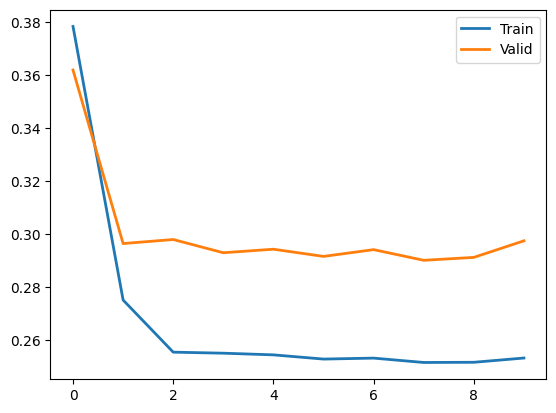

In [43]:
plt.plot(lstm_autoencoder_history_both['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history_both['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


Text(0, 0.5, 'Number of Samples')

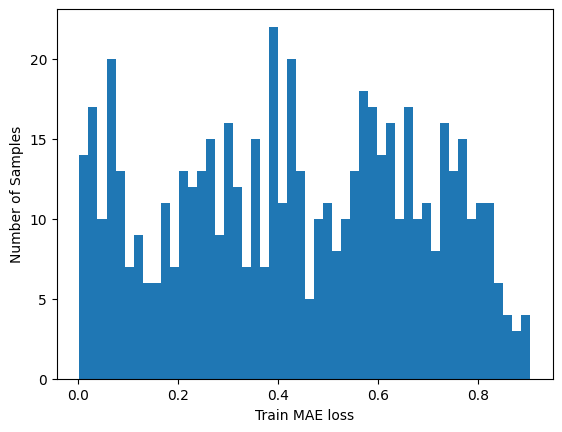

In [44]:
# Mean Absolute Error loss
x_train_pred = lstm_autoencoder_both.predict(x_train_both)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train_both), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')

In [45]:
threshold = np.median(train_mae_loss)
threshold

0.4314975721550772

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Text(0, 0.5, 'Number of samples')

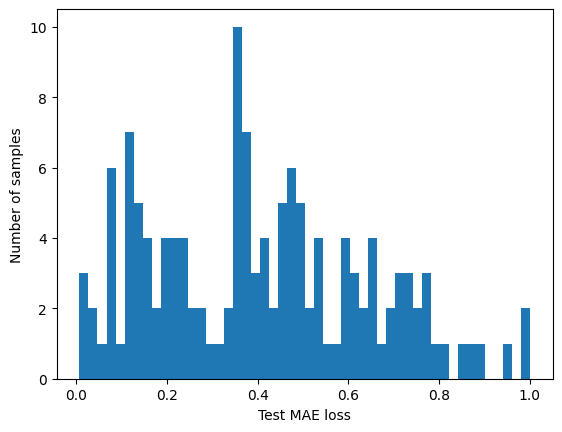

In [46]:
X_test_pred = lstm_autoencoder_both.predict(x_test_both, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-x_test_both), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [47]:
anomaly_df_both = test.copy()
anomaly_df_both.loc[:, 'loss'] = test_mae_loss
anomaly_df_both.loc[:, 'threshold'] = threshold
anomaly_df_both.loc[:, 'anomaly'] = anomaly_df_both['loss'] > anomaly_df_both['threshold']
anomaly_df_both

,timestamp,humidity,humidity_status,humidity_standar,loss,threshold,anomaly
864,2023-01-04 00:00:00,67.93,0,0.670303,0.161385,0.431498,False
865,2023-01-04 00:05:00,47.10,0,0.721751,0.110276,0.431498,False
866,2023-01-04 00:10:00,79.69,1,1.456215,0.619337,0.431498,True
867,2023-01-04 00:15:00,65.35,0,0.497883,0.332667,0.431498,False
868,2023-01-04 00:20:00,43.16,0,0.985059,0.151293,0.431498,False
...,...,...,...,...,...,...,...
995,2023-01-04 10:55:00,57.36,0,0.036083,0.791421,0.431498,True
996,2023-01-04 11:00:00,77.07,1,1.281122,0.445401,0.431498,True
997,2023-01-04 11:05:00,72.28,1,0.961010,0.127403,0.431498,False
998,2023-01-04 11:10:00,68.69,0,0.721093,0.110930,0.431498,False


In [48]:
anomaly_df_both.loc[anomaly_df_both['anomaly']==True].count()

timestamp           60
humidity            60
humidity_status     60
humidity_standar    60
loss                60
threshold           60
anomaly             60
dtype: int64

In [49]:
anomaly_df_both.loc[anomaly_df_both['anomaly']==False].count()

timestamp           76
humidity            76
humidity_status     76
humidity_standar    76
loss                76
threshold           76
anomaly             76
dtype: int64

In [50]:
anomaly_df_temp_status=anomaly_df_both["humidity_status"].astype(int)
anomaly_df_predicted=anomaly_df_both["anomaly"].astype(int)

In [51]:
report=classification_report(anomaly_df_temp_status, anomaly_df_predicted)
print(report)
conf=confusion_matrix(anomaly_df_temp_status, anomaly_df_predicted)
print(conf)

              precision    recall  f1-score   support

           0       0.66      0.65      0.65        77
           1       0.55      0.56      0.55        59

    accuracy                           0.61       136
   macro avg       0.60      0.60      0.60       136
weighted avg       0.61      0.61      0.61       136

[[50 27]
 [26 33]]
